In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV with multi-row header
file_path = '/Users/macbook/Desktop/Lab/deeplabcut/Wrist_angle/csv_files/clipped_camera_2DLC_Resnet50_test5Mar20shuffle4_snapshot_090_filtered.csv'
df = pd.read_csv(file_path, header=[0, 1, 2])

# Adjust the parameter to better detect peaks
distance = 160
window = 180
remove_peaks = 3 #remove the first few peaks 


In [75]:
def get_joint_data(joint):
    x = df.xs((joint, 'x'), level=(1, 2), axis=1)
    y = df.xs((joint, 'y'), level=(1, 2), axis=1)
    likelihood = df.xs((joint, 'likelihood'), level=(1, 2), axis=1)
    return x.squeeze(), y.squeeze(), likelihood.squeeze()



In [76]:
fw_x, fw_y, fw_lh= get_joint_data('forearm')
wr_x, wr_y, wr_lh= get_joint_data('wrist')
mc_x, mc_y, mc_lh= get_joint_data('MCP')


In [77]:
#Filter jumpy frames


#Likelihood filter
likelihood_threshold = 0.6  # Adjust likelihood_threshold
lh_mask = (fw_lh > likelihood_threshold) & (wr_lh > likelihood_threshold) & (mc_lh > likelihood_threshold)


#Smoothness filter
def calc_speed(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    speed = np.sqrt(dx**2 + dy**2)
    return np.insert(speed, 0, 0)  # insert 0 at start to match length

fw_speed = calc_speed(fw_x, fw_y)
wr_speed = calc_speed(wr_x, wr_y)
mc_speed = calc_speed(mc_x, mc_y)


threshold = 1000  # Adjust threshold
speed_mask = (fw_speed < threshold) & (wr_speed < threshold) & (mc_speed < threshold)




valid = lh_mask & speed_mask

fw_x, fw_y = fw_x[valid], fw_y[valid]
wr_x, wr_y = wr_x[valid], wr_y[valid]
mc_x, mc_y = mc_x[valid], mc_y[valid]

In [78]:
# Vectors
vec_a = np.stack([fw_x - wr_x, fw_y - wr_y], axis=1)  # forearm to wrist
vec_b = np.stack([mc_x - wr_x, mc_y - wr_y], axis=1)  # MCP to wrist

# Normalize vectors
norm_a = np.linalg.norm(vec_a, axis=1)
norm_b = np.linalg.norm(vec_b, axis=1)

# Compute angle using dot product
dot_prod = np.einsum('ij,ij->i', vec_a, vec_b)
angles_rad = np.arccos(dot_prod / (norm_a * norm_b))

# Convert to degrees
angles_deg = np.degrees(angles_rad)

In [79]:
from scipy.ndimage import gaussian_filter1d

# Gaussian smoothing (sigma=10)
wrist_angle = gaussian_filter1d(angles_deg, sigma=10)

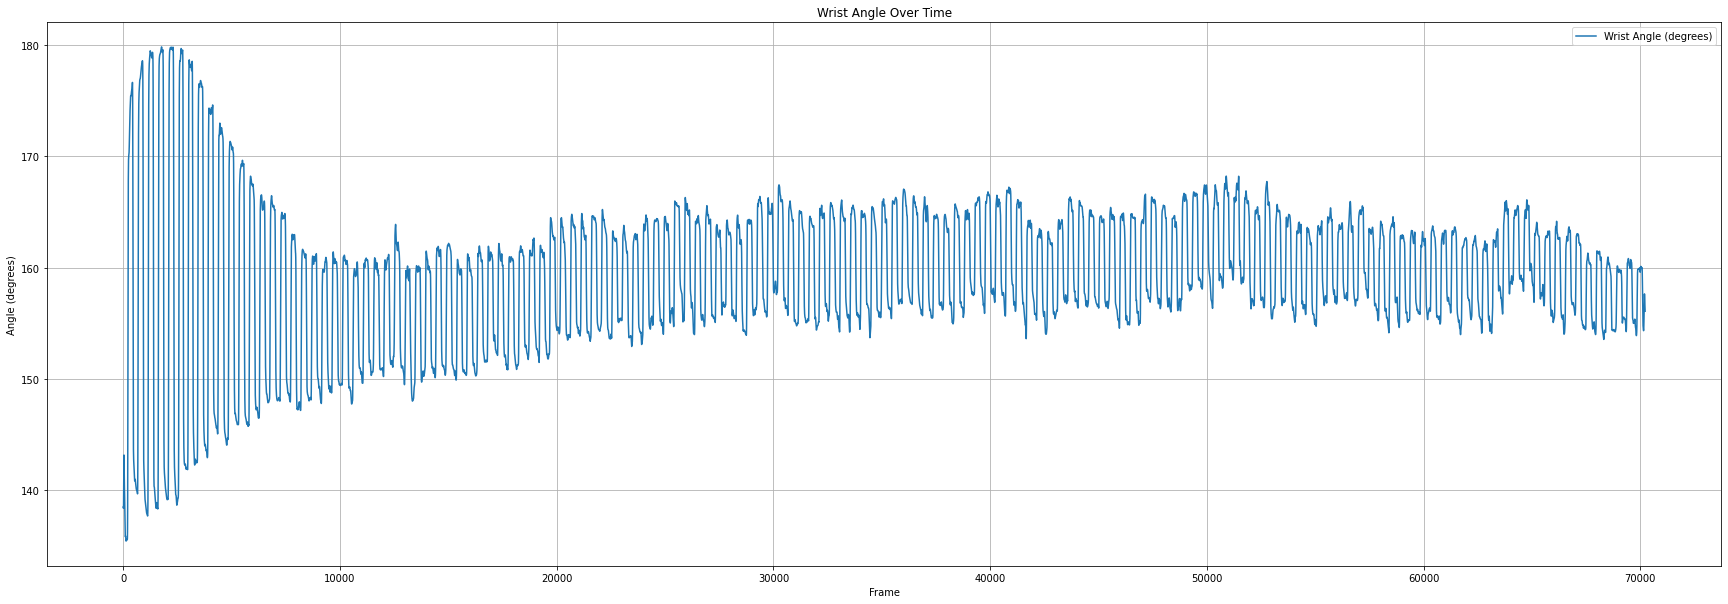

In [80]:
# Plot the wrist angle over time
plt.figure(figsize=(30, 10))
plt.plot(wrist_angle, label='Wrist Angle (degrees)')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Wrist Angle Over Time')
plt.legend()
plt.grid(True)
plt.show()

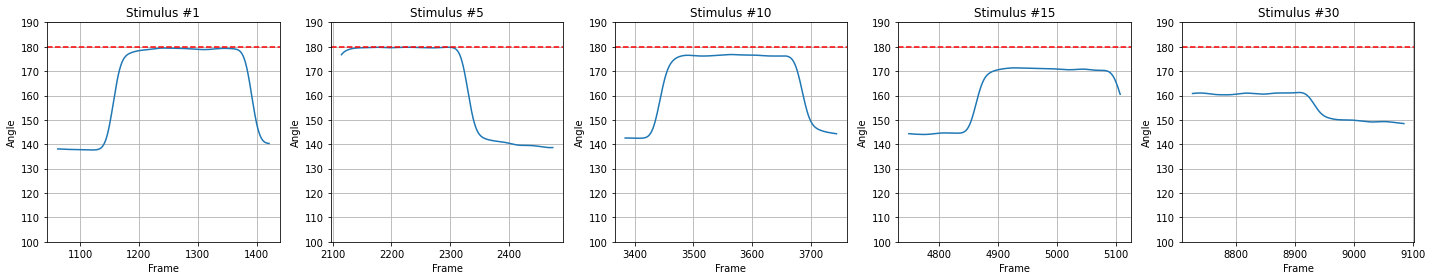

In [ ]:
from scipy.signal import find_peaks

# Detect peaks
peaks, _ = find_peaks(wrist_angle, distance=distance)  

peaks = peaks[remove_peaks:]
stim_indices = [0, 4, 9, 14, 29]  
amplitudes = []



plt.figure(figsize=(20, 4))

for i, idx in enumerate(stim_indices):
    center = peaks[idx]
    start = max(center - window, 0)
    end = min(center + window, len(wrist_angle))
    segment = wrist_angle[start:end]
    
    plt.subplot(1, len(stim_indices), i+1)
    plt.plot(np.arange(start, end), segment)
    plt.axhline(180, color='red', linestyle='--')
    plt.title(f"Stimulus #{idx + 1}")
    plt.xlabel("Frame")
    plt.ylabel("Angle")
    plt.ylim(100, 190)
    plt.grid(True)

plt.tight_layout()
plt.show()



In [71]:
# Absolute amplitude
for idx in range(len(peaks)):
    center = peaks[idx]
    start = max(center - window, 0)
    end = min(center + window, len(wrist_angle))
    segment = wrist_angle[start:end]

    amp = np.max(segment) 
    amplitudes.append(amp)

stim_numbers = np.arange(1, len(peaks) + 1)



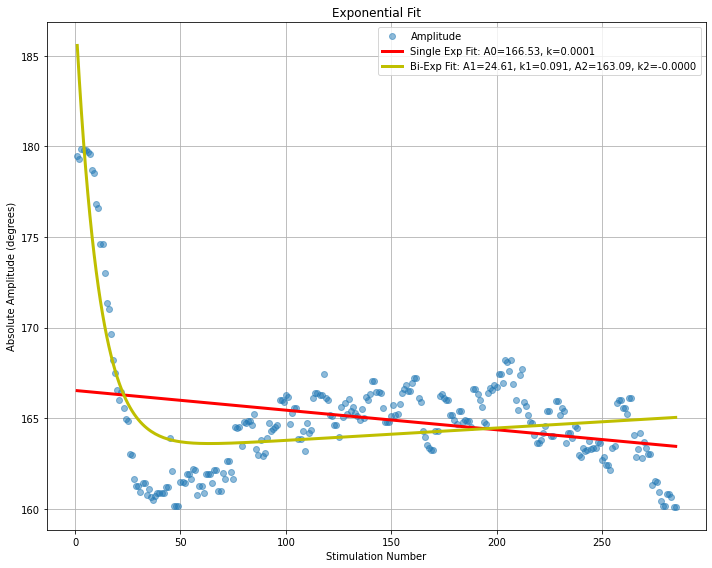

In [72]:
from scipy.optimize import curve_fit

# Define Single Exponential decay
def exp_decay(n, A0, k):
    return A0 * np.exp(-k * n)

# Define Bi-Exponential decay
def bi_exp_decay(n, A1, k1, A2, k2):
    return A1 * np.exp(-k1 * n) + A2 * np.exp(-k2 * n)

# fit 
popt_single, _ = curve_fit(exp_decay, stim_numbers, amplitudes, p0=(amplitudes[0], 0.01))
fit_single = exp_decay(stim_numbers, *popt_single)

# fit
popt_bi, _ = curve_fit(bi_exp_decay, stim_numbers, amplitudes, p0=(20, 0.1, 10, 0.01), maxfev=10000)
fit_bi = bi_exp_decay(stim_numbers, *popt_bi)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(stim_numbers, amplitudes, 'o', label='Amplitude', alpha=0.5)
plt.plot(stim_numbers, fit_single, 'r-', lw=3, label=f'Single Exp Fit: A0={popt_single[0]:.2f}, k={popt_single[1]:.4f}')
plt.plot(stim_numbers, fit_bi, 'y-', lw=3, label=(
    f'Bi-Exp Fit: A1={popt_bi[0]:.2f}, k1={popt_bi[1]:.3f}, A2={popt_bi[2]:.2f}, k2={popt_bi[3]:.4f}'))

plt.title("Exponential Fit")
plt.xlabel("Stimulation Number")
plt.ylabel("Absolute Amplitude (degrees)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()